Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'ETHBTC'
symbols = {'ETHBTC': None, 
           'BTCUSDT': None, 
           'ETHUSDT': None, 
           'BNBBTC': None, 
           'BNBETH': None, 
           'BNBUSDT': None}
percentage_to_trade = 0.99
interval = '1m'
window_1 = 1
window_2 = 1
period = '1 hour ago UTC'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_moving_average(dataset, window=2, method='simple'):
    if method == 'simple':
        dataset = dataset.rolling(window=window)
    elif method == 'exponential':
        dataset = dataset.ewm(span=window)

    dataset = dataset.mean()
    dataset = dataset.fillna(method='backfill', axis='index')
    return dataset

def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def calculate_RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    ticker = ticker.fillna(method='pad').to_frame(name='MACD')
    ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
    ticker['histogram'] = ticker.MACD - ticker.signal_line
    return ticker

def calculate_ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def calculate_average_directional_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df.ADX.dropna()

def calculate_commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume']]

    dataset_downloaded.set_index('time', inplace=True)
    dataset_downloaded = dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))
    return dataset_downloaded

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()
        self.state = 'entry'

    def calculate_position(self):
        if self.base_asset_buy_balance > self.base_asset_sell_balance:
            self.position = 'sell'
        elif self.base_asset_sell_balance > self.base_asset_buy_balance:
            self.position = 'buy'

    def calculate_balance(self):
        self.quote_asset_buy_balance = float(client.get_asset_balance(asset=self.quote_asset)['free'])
        self.base_asset_buy_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.base_asset_buy_balance = self.quote_asset_buy_balance / self.base_asset_buy_last_price
        self.base_asset_sell_balance = float(client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_sell_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.quote_asset_sell_balance = self.base_asset_sell_balance * self.quote_asset_sell_last_price
        self.quote_asset_balance_combined = self.quote_asset_sell_balance + self.quote_asset_buy_balance
        self.base_asset_balance_combined = self.base_asset_buy_balance + self.base_asset_sell_balance

    def calculate_indicators(self):
        dataset = self.dataset.astype(float)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_1, method='simple')
        self.heikin_ashi = calculate_heikin_ashi(self.heikin_ashi)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_2, method='exponential')
        self.RSI_6 = calculate_RSI(dataset, span=6)
        self.RSI_12 = calculate_RSI(dataset, span=12)
        self.CCI = calculate_commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = calculate_ATR(dataset, min_periods=14).median()
        self.renko = calculate_renko(dataset, brick_size=self.brick_size)
        self.ADX = calculate_average_directional_index(dataset, n=14, n_ADX=14)
        self.KDJ = calculate_KDJ(dataset)
        self.MACD = calculate_MACD(dataset)
        self.bollinger_bands = calculate_bollinger_bands(dataset, period=20)
        self.trend_trigger = (self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0
        self.overtraded_trigger = self.RSI_6 > self.RSI_12
        self.trend_strength_trigger = self.ADX > 0.20
        self.momentum_trigger = self.KDJ['J'] > self.KDJ['D']
        self.volatility_trigger = (self.bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def print_balance(self):
        print('quote_asset_buy_balance: ', self.quote_asset_buy_balance)
        print('base_asset_buy_last_price: ', self.base_asset_buy_last_price)
        print('base_asset_buy_balance: ', self.base_asset_buy_balance)
        print('base_asset_sell_balance: ', self.base_asset_sell_balance)
        print('quote_asset_sell_last_price: ', self.quote_asset_sell_last_price)
        print('quote_asset_sell_balance: ', self.quote_asset_sell_balance)
        print('quote_asset_balance_combined: ', self.quote_asset_balance_combined)
        print('base_asset_balance_combined: ', self.base_asset_balance_combined)

    def trade(self):
        self.calculate_balance()

        if self.position == 'sell':
            coins_available = self.base_asset_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.base_asset_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.step_size) / float(10**self.step_size)

        if self.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.tick_size)) / float(abs(self.tick_size))

        client.create_order(symbol=self.symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position

In [5]:
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)

                         open      high       low     close   volume
time                                                                
2020-04-26 10:58:00  0.025589  0.025595  0.025584  0.025591   62.441
2020-04-26 10:59:00   0.02559  0.025595  0.025584  0.025588   69.086
2020-04-26 11:00:00  0.025585  0.025591  0.025575  0.025588   80.283
2020-04-26 11:01:00  0.025588  0.025591  0.025576  0.025586   92.645
2020-04-26 11:02:00  0.025581  0.025589  0.025577   0.02558   32.929
2020-04-26 11:03:00   0.02558  0.025589  0.025577  0.025584   63.604
2020-04-26 11:04:00  0.025584  0.025585  0.025583  0.025585    2.283
2020-04-26 11:05:00  0.025583  0.025589   0.02557  0.025583  143.162
2020-04-26 11:06:00  0.025585  0.025589  0.025582  0.025582   58.386
2020-04-26 11:07:00   0.02559  0.025596   0.02559  0.025593   13.456
2020-04-26 11:08:00  0.025593  0.025603  0.025592  0.025595    67.42
2020-04-26 11:09:00  0.025596  0.025605  0.025595  0.025605   72.501
2020-04-26 11:10:00  0.025607  0.0

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

ETHBTC
                         open      high       low     close   volume
time                                                                
2020-04-26 10:58:00  0.025589  0.025595  0.025584  0.025591   62.441
2020-04-26 10:59:00  0.025590  0.025595  0.025584  0.025588   69.086
2020-04-26 11:00:00  0.025585  0.025591  0.025575  0.025588   80.283
2020-04-26 11:01:00  0.025588  0.025591  0.025576  0.025586   92.645
2020-04-26 11:02:00  0.025581  0.025589  0.025577  0.025580   32.929
2020-04-26 11:03:00  0.025580  0.025589  0.025577  0.025584   63.604
2020-04-26 11:04:00  0.025584  0.025585  0.025583  0.025585    2.283
2020-04-26 11:05:00  0.025583  0.025589  0.025570  0.025583  143.162
2020-04-26 11:06:00  0.025585  0.025589  0.025582  0.025582   58.386
2020-04-26 11:07:00  0.025590  0.025596  0.025590  0.025593   13.456
2020-04-26 11:08:00  0.025593  0.025603  0.025592  0.025595   67.420
2020-04-26 11:09:00  0.025596  0.025605  0.025595  0.025605   72.501
2020-04-26 11:10:00  0.0256

BTCUSDT
                        open     high      low    close      volume
time                                                               
2020-04-26 10:58:00  7622.79  7624.98  7621.11  7624.00   22.778197
2020-04-26 10:59:00  7624.00  7627.74  7622.00  7624.51   41.727320
2020-04-26 11:00:00  7624.02  7624.59  7617.54  7618.10   33.767006
2020-04-26 11:01:00  7617.76  7618.16  7612.00  7612.72   46.241851
2020-04-26 11:02:00  7613.41  7618.16  7612.84  7615.70   35.923657
2020-04-26 11:03:00  7615.70  7618.15  7612.62  7614.31   27.801185
2020-04-26 11:04:00  7614.37  7618.16  7614.25  7614.93   26.721599
2020-04-26 11:05:00  7614.94  7615.71  7608.78  7612.00   38.989546
2020-04-26 11:06:00  7612.00  7615.32  7611.96  7611.99   13.324643
2020-04-26 11:07:00  7611.99  7617.43  7611.60  7616.93   24.088371
2020-04-26 11:08:00  7617.60  7618.16  7616.01  7618.15   13.500959
2020-04-26 11:09:00  7618.15  7618.16  7615.03  7615.84   11.331950
2020-04-26 11:10:00  7615.61  7616.00  7

ETHUSDT
                       open    high     low   close      volume
time                                                           
2020-04-26 10:58:00  195.08  195.14  195.03  195.08   331.95692
2020-04-26 10:59:00  195.09  195.15  195.05  195.09   325.22714
2020-04-26 11:00:00  195.10  195.10  194.88  194.95   541.52382
2020-04-26 11:01:00  194.92  194.95  194.76  194.78   531.17298
2020-04-26 11:02:00  194.79  194.93  194.79  194.82   430.76524
2020-04-26 11:03:00  194.82  194.87  194.75  194.78   322.44255
2020-04-26 11:04:00  194.77  194.81  194.75  194.80    42.10534
2020-04-26 11:05:00  194.80  194.81  194.58  194.75   806.92349
2020-04-26 11:06:00  194.74  194.82  194.71  194.81   182.81938
2020-04-26 11:07:00  194.80  194.98  194.79  194.94   360.21197
2020-04-26 11:08:00  194.95  195.00  194.95  195.00    95.10511
2020-04-26 11:09:00  194.99  195.03  194.95  195.01   322.55880
2020-04-26 11:10:00  195.01  195.02  194.92  194.98   299.30733
2020-04-26 11:11:00  194.98  195

BNBBTC
                         open      high       low     close   volume
time                                                                
2020-04-26 10:58:00  0.002144  0.002144  0.002143  0.002144   713.54
2020-04-26 10:59:00  0.002144  0.002145  0.002143  0.002145   347.81
2020-04-26 11:00:00  0.002145  0.002145  0.002144  0.002145   344.70
2020-04-26 11:01:00  0.002145  0.002145  0.002144  0.002144   400.10
2020-04-26 11:02:00  0.002143  0.002143  0.002142  0.002143    39.47
2020-04-26 11:03:00  0.002143  0.002143  0.002142  0.002142  2103.68
2020-04-26 11:04:00  0.002143  0.002143  0.002141  0.002142   464.54
2020-04-26 11:05:00  0.002141  0.002142  0.002139  0.002139   642.67
2020-04-26 11:06:00  0.002139  0.002140  0.002139  0.002139   503.57
2020-04-26 11:07:00  0.002140  0.002143  0.002140  0.002142   635.08
2020-04-26 11:08:00  0.002142  0.002142  0.002142  0.002142    93.72
2020-04-26 11:09:00  0.002142  0.002143  0.002139  0.002140   924.50
2020-04-26 11:10:00  0.0021

BNBETH
                         open      high       low     close  volume
time                                                               
2020-04-26 10:58:00  0.083753  0.083845  0.083731  0.083731   79.63
2020-04-26 10:59:00  0.083753  0.083753  0.083735  0.083735    5.40
2020-04-26 11:00:00  0.083736  0.083736  0.083735  0.083735   33.43
2020-04-26 11:01:00  0.083735  0.083735  0.083735  0.083735    0.00
2020-04-26 11:02:00  0.083733  0.083733  0.083731  0.083731  127.55
2020-04-26 11:03:00  0.083735  0.083735  0.083731  0.083731    1.81
2020-04-26 11:04:00  0.083831  0.083831  0.083716  0.083716   11.39
2020-04-26 11:05:00  0.083716  0.083828  0.083633  0.083633    7.23
2020-04-26 11:06:00  0.083628  0.083628  0.083612  0.083612    8.78
2020-04-26 11:07:00  0.083600  0.083600  0.083600  0.083600   10.95
2020-04-26 11:08:00  0.083605  0.083605  0.083604  0.083604   13.44
2020-04-26 11:09:00  0.083604  0.083604  0.083544  0.083544   11.27
2020-04-26 11:10:00  0.083600  0.083600  

BNBUSDT
                        open     high      low    close    volume
time                                                             
2020-04-26 10:58:00  16.3373  16.3465  16.3371  16.3398   1948.78
2020-04-26 10:59:00  16.3466  16.3531  16.3396  16.3515   2058.04
2020-04-26 11:00:00  16.3523  16.3574  16.3393  16.3420   1623.38
2020-04-26 11:01:00  16.3420  16.3420  16.3143  16.3169   1121.37
2020-04-26 11:02:00  16.3157  16.3217  16.3105  16.3120   1145.80
2020-04-26 11:03:00  16.3130  16.3258  16.3101  16.3127   1492.85
2020-04-26 11:04:00  16.3172  16.3172  16.3031  16.3031   4748.59
2020-04-26 11:05:00  16.3077  16.3077  16.2778  16.2825   1859.25
2020-04-26 11:06:00  16.2825  16.2904  16.2824  16.2861    903.49
2020-04-26 11:07:00  16.2861  16.3213  16.2861  16.3123   3421.22
2020-04-26 11:08:00  16.3125  16.3229  16.3124  16.3229    879.08
2020-04-26 11:09:00  16.3144  16.3216  16.2904  16.2979  14334.98
2020-04-26 11:10:00  16.2914  16.2996  16.2908  16.2918   2263.90
20

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00   -0.887936
2020-04-26 11:18:00   -0.780322
2020-04-26 11:19:00   -0.607248
2020-04-26 11:20:00   -0.109976
2020-04-26 11:21:00   -0.376334
2020-04-26 11:22:00   -0.279194
2020-04-26 11:23:00   -0.343998
2020-04-26 11:24:00   -1.311986
2020-04-26 11:25:00   -1.411446
2020-04-26 11:26:00   -1.167606
2020-04-26 11:27:00   -0.733506
2020-04-26 11:28:00   -0.465437
202

/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



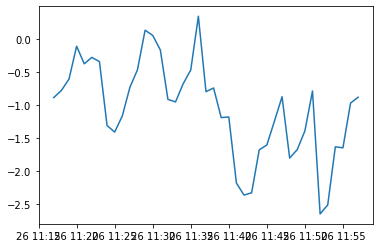

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00    1.186577
2020-04-26 11:18:00    1.024481
2020-04-26 11:19:00    0.527034
2020-04-26 11:20:00    0.384026
2020-04-26 11:21:00    1.269974
2020-04-26 11:22:00    0.705922
2020-04-26 11:23:00    1.491709
2020-04-26 11:24:00    1.539651
2020-04-26 11:25:00    1.188441
2020-04-26 11:26:00    0.248094
2020-04-26 11:27:00   -0.617453
2020-04-26 11:28:00   -0.079083
202

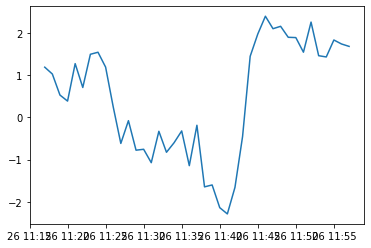

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00    0.557683
2020-04-26 11:18:00    0.514070
2020-04-26 11:19:00    0.097401
2020-04-26 11:20:00   -0.126046
2020-04-26 11:21:00    0.938640
2020-04-26 11:22:00    0.415820
2020-04-26 11:23:00    0.766110
2020-04-26 11:24:00    0.611262
2020-04-26 11:25:00   -0.115218
2020-04-26 11:26:00   -1.947234
2020-04-26 11:27:00   -1.981531
2020-04-26 11:28:00   -0.624620
202

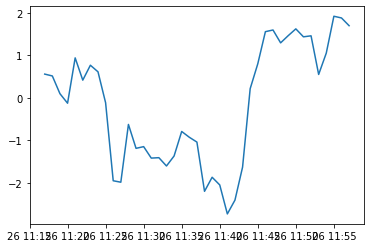

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00   -1.216687
2020-04-26 11:18:00   -1.349663
2020-04-26 11:19:00   -0.965528
2020-04-26 11:20:00    0.061905
2020-04-26 11:21:00    0.750029
2020-04-26 11:22:00    2.455270
2020-04-26 11:23:00    1.987153
2020-04-26 11:24:00    1.533526
2020-04-26 11:25:00    1.726856
2020-04-26 11:26:00    1.555420
2020-04-26 11:27:00    1.384081
2020-04-26 11:28:00    1.306061
202

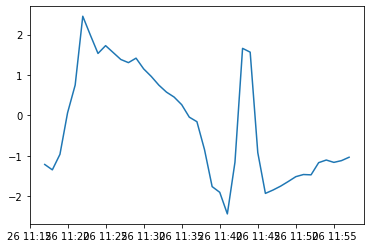

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00    0.211356
2020-04-26 11:18:00   -0.336563
2020-04-26 11:19:00   -0.265582
2020-04-26 11:20:00   -0.191969
2020-04-26 11:21:00    0.507133
2020-04-26 11:22:00    2.416176
2020-04-26 11:23:00    0.879314
2020-04-26 11:24:00    2.856500
2020-04-26 11:25:00    2.438160
2020-04-26 11:26:00    1.929681
2020-04-26 11:27:00    1.102868
2020-04-26 11:28:00    1.368218
202

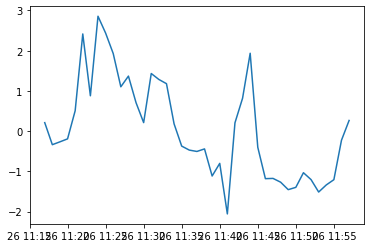

time
2020-04-26 10:58:00         NaN
2020-04-26 10:59:00         NaN
2020-04-26 11:00:00         NaN
2020-04-26 11:01:00         NaN
2020-04-26 11:02:00         NaN
2020-04-26 11:03:00         NaN
2020-04-26 11:04:00         NaN
2020-04-26 11:05:00         NaN
2020-04-26 11:06:00         NaN
2020-04-26 11:07:00         NaN
2020-04-26 11:08:00         NaN
2020-04-26 11:09:00         NaN
2020-04-26 11:10:00         NaN
2020-04-26 11:11:00         NaN
2020-04-26 11:12:00         NaN
2020-04-26 11:13:00         NaN
2020-04-26 11:14:00         NaN
2020-04-26 11:15:00         NaN
2020-04-26 11:16:00         NaN
2020-04-26 11:17:00   -0.738428
2020-04-26 11:18:00   -0.818160
2020-04-26 11:19:00   -0.547304
2020-04-26 11:20:00    0.259841
2020-04-26 11:21:00    1.887772
2020-04-26 11:22:00    2.867961
2020-04-26 11:23:00    2.268567
2020-04-26 11:24:00    2.030343
2020-04-26 11:25:00    2.019994
2020-04-26 11:26:00    1.638934
2020-04-26 11:27:00    1.176549
2020-04-26 11:28:00    1.060853
202

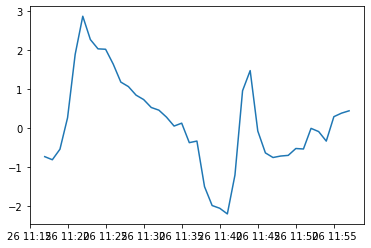

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-04-26 10:58:00     True
2020-04-26 11:09:00     True
2020-04-26 11:16:00    False
2020-04-26 11:48:00    False
2020-04-26 11:52:00    False
Name: uptrend, dtype: bool


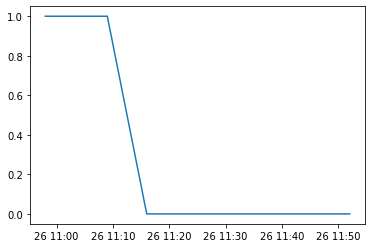

time
2020-04-26 10:58:00    True
2020-04-26 11:46:00    True
2020-04-26 11:51:00    True
2020-04-26 11:55:00    True
2020-04-26 11:56:00    True
Name: uptrend, dtype: bool


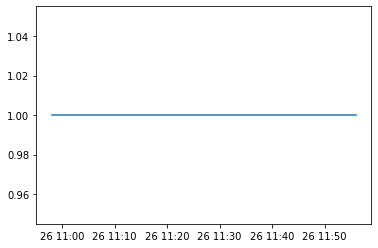

time
2020-04-26 10:58:00     True
2020-04-26 11:41:00    False
2020-04-26 11:49:00     True
2020-04-26 11:55:00     True
Name: uptrend, dtype: bool


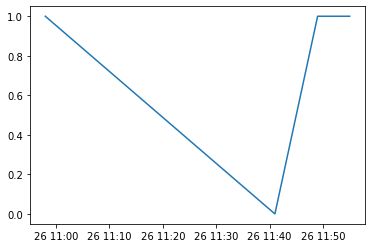

time
2020-04-26 10:58:00     True
2020-04-26 10:59:00     True
2020-04-26 11:05:00    False
2020-04-26 11:17:00    False
2020-04-26 11:22:00     True
2020-04-26 11:22:00     True
2020-04-26 11:41:00    False
2020-04-26 11:43:00     True
2020-04-26 11:43:00     True
2020-04-26 11:45:00    False
2020-04-26 11:45:00    False
2020-04-26 11:51:00    False
Name: uptrend, dtype: bool


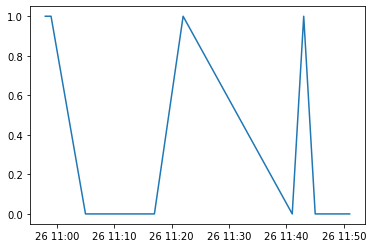

time
2020-04-26 10:58:00     True
2020-04-26 11:09:00    False
2020-04-26 11:22:00     True
2020-04-26 11:22:00     True
2020-04-26 11:41:00    False
2020-04-26 11:42:00     True
2020-04-26 11:43:00     True
2020-04-26 11:44:00     True
2020-04-26 11:45:00    False
2020-04-26 11:46:00    False
2020-04-26 11:49:00    False
2020-04-26 11:52:00    False
Name: uptrend, dtype: bool


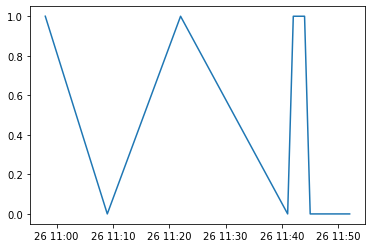

time
2020-04-26 10:58:00     True
2020-04-26 10:59:00     True
2020-04-26 11:04:00    False
2020-04-26 11:05:00    False
2020-04-26 11:22:00     True
2020-04-26 11:25:00     True
2020-04-26 11:38:00    False
2020-04-26 11:41:00    False
2020-04-26 11:43:00     True
2020-04-26 11:43:00     True
2020-04-26 11:47:00    False
Name: uptrend, dtype: bool


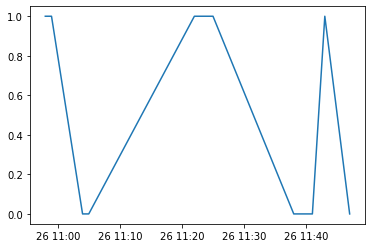

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-04-26 11:24:00    0.268057
2020-04-26 11:25:00    0.297211
2020-04-26 11:26:00    0.304923
2020-04-26 11:27:00    0.281762
2020-04-26 11:28:00    0.249431
2020-04-26 11:29:00    0.222067
2020-04-26 11:30:00    0.195458
2020-04-26 11:31:00    0.211507
2020-04-26 11:32:00    0.225209
2020-04-26 11:33:00    0.236932
2020-04-26 11:34:00    0.229140
2020-04-26 11:35:00    0.205874
2020-04-26 11:36:00    0.215177
2020-04-26 11:37:00    0.228124
2020-04-26 11:38:00    0.253094
2020-04-26 11:39:00    0.274619
2020-04-26 11:40:00    0.315605
2020-04-26 11:41:00    0.358956
2020-04-26 11:42:00    0.405063
2020-04-26 11:43:00    0.384608
2020-04-26 11:44:00    0.366927
2020-04-26 11:45:00    0.351637
2020-04-26 11:46:00    0.329226
2020-04-26 11:47:00    0.343303
2020-04-26 11:48:00    0.355486
2020-04-26 11:49:00    0.346002
2020-04-26 11:50:00    0.311504
2020-04-26 11:51:00    0.349022
2020-04-26 11:52:00    0.381511
2020-04-26 11:53:00    0.372694
2020-04-26 11:54:00    0.370784
202

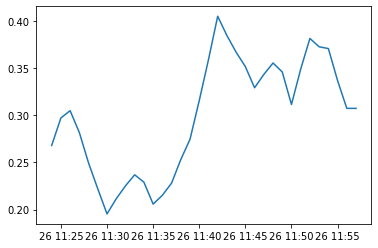

time
2020-04-26 11:24:00    0.336659
2020-04-26 11:25:00    0.290986
2020-04-26 11:26:00    0.279248
2020-04-26 11:27:00    0.269399
2020-04-26 11:28:00    0.271099
2020-04-26 11:29:00    0.272538
2020-04-26 11:30:00    0.284757
2020-04-26 11:31:00    0.273195
2020-04-26 11:32:00    0.283565
2020-04-26 11:33:00    0.292438
2020-04-26 11:34:00    0.299819
2020-04-26 11:35:00    0.339278
2020-04-26 11:36:00    0.348146
2020-04-26 11:37:00    0.374531
2020-04-26 11:38:00    0.401506
2020-04-26 11:39:00    0.434436
2020-04-26 11:40:00    0.473932
2020-04-26 11:41:00    0.508026
2020-04-26 11:42:00    0.465853
2020-04-26 11:43:00    0.422259
2020-04-26 11:44:00    0.384575
2020-04-26 11:45:00    0.371350
2020-04-26 11:46:00    0.366440
2020-04-26 11:47:00    0.369960
2020-04-26 11:48:00    0.373007
2020-04-26 11:49:00    0.388479
2020-04-26 11:50:00    0.364637
2020-04-26 11:51:00    0.397953
2020-04-26 11:52:00    0.426188
2020-04-26 11:53:00    0.451124
2020-04-26 11:54:00    0.487844
202

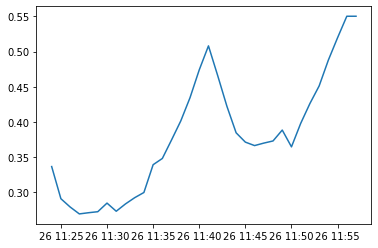

time
2020-04-26 11:24:00    0.291556
2020-04-26 11:25:00    0.269055
2020-04-26 11:26:00    0.231010
2020-04-26 11:27:00    0.199090
2020-04-26 11:28:00    0.172180
2020-04-26 11:29:00    0.149404
2020-04-26 11:30:00    0.154272
2020-04-26 11:31:00    0.158419
2020-04-26 11:32:00    0.177215
2020-04-26 11:33:00    0.193297
2020-04-26 11:34:00    0.197067
2020-04-26 11:35:00    0.222320
2020-04-26 11:36:00    0.207787
2020-04-26 11:37:00    0.217119
2020-04-26 11:38:00    0.225156
2020-04-26 11:39:00    0.254816
2020-04-26 11:40:00    0.312587
2020-04-26 11:41:00    0.362456
2020-04-26 11:42:00    0.335414
2020-04-26 11:43:00    0.321950
2020-04-26 11:44:00    0.315139
2020-04-26 11:45:00    0.330108
2020-04-26 11:46:00    0.346663
2020-04-26 11:47:00    0.360986
2020-04-26 11:48:00    0.373382
2020-04-26 11:49:00    0.391244
2020-04-26 11:50:00    0.386319
2020-04-26 11:51:00    0.407924
2020-04-26 11:52:00    0.389317
2020-04-26 11:53:00    0.393828
2020-04-26 11:54:00    0.424800
202

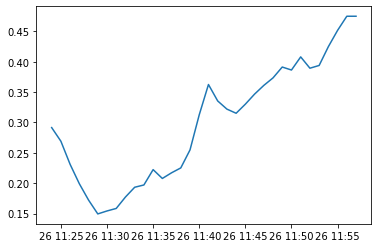

time
2020-04-26 11:24:00    0.441120
2020-04-26 11:25:00    0.472316
2020-04-26 11:26:00    0.501136
2020-04-26 11:27:00    0.490912
2020-04-26 11:28:00    0.482294
2020-04-26 11:29:00    0.442664
2020-04-26 11:30:00    0.409008
2020-04-26 11:31:00    0.380343
2020-04-26 11:32:00    0.333731
2020-04-26 11:33:00    0.293851
2020-04-26 11:34:00    0.287216
2020-04-26 11:35:00    0.289862
2020-04-26 11:36:00    0.294988
2020-04-26 11:37:00    0.326332
2020-04-26 11:38:00    0.353331
2020-04-26 11:39:00    0.382340
2020-04-26 11:40:00    0.422294
2020-04-26 11:41:00    0.387399
2020-04-26 11:42:00    0.392076
2020-04-26 11:43:00    0.396116
2020-04-26 11:44:00    0.370798
2020-04-26 11:45:00    0.360318
2020-04-26 11:46:00    0.355908
2020-04-26 11:47:00    0.352092
2020-04-26 11:48:00    0.351084
2020-04-26 11:49:00    0.358391
2020-04-26 11:50:00    0.364717
2020-04-26 11:51:00    0.378971
2020-04-26 11:52:00    0.374908
2020-04-26 11:53:00    0.379032
2020-04-26 11:54:00    0.382604
202

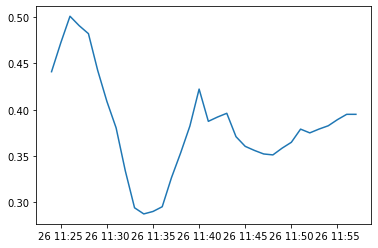

time
2020-04-26 11:24:00    0.484905
2020-04-26 11:25:00    0.518214
2020-04-26 11:26:00    0.480065
2020-04-26 11:27:00    0.452544
2020-04-26 11:28:00    0.412571
2020-04-26 11:29:00    0.378739
2020-04-26 11:30:00    0.391982
2020-04-26 11:31:00    0.403262
2020-04-26 11:32:00    0.412892
2020-04-26 11:33:00    0.362908
2020-04-26 11:34:00    0.320066
2020-04-26 11:35:00    0.283290
2020-04-26 11:36:00    0.251680
2020-04-26 11:37:00    0.231677
2020-04-26 11:38:00    0.230941
2020-04-26 11:39:00    0.230306
2020-04-26 11:40:00    0.259386
2020-04-26 11:41:00    0.242253
2020-04-26 11:42:00    0.241508
2020-04-26 11:43:00    0.256363
2020-04-26 11:44:00    0.222917
2020-04-26 11:45:00    0.210165
2020-04-26 11:46:00    0.199134
2020-04-26 11:47:00    0.194536
2020-04-26 11:48:00    0.199857
2020-04-26 11:49:00    0.204965
2020-04-26 11:50:00    0.190438
2020-04-26 11:51:00    0.167394
2020-04-26 11:52:00    0.147438
2020-04-26 11:53:00    0.130156
2020-04-26 11:54:00    0.115187
202

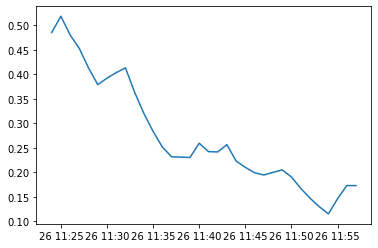

time
2020-04-26 11:24:00    0.417404
2020-04-26 11:25:00    0.455968
2020-04-26 11:26:00    0.463563
2020-04-26 11:27:00    0.434812
2020-04-26 11:28:00    0.421509
2020-04-26 11:29:00    0.402247
2020-04-26 11:30:00    0.385889
2020-04-26 11:31:00    0.371956
2020-04-26 11:32:00    0.336424
2020-04-26 11:33:00    0.301456
2020-04-26 11:34:00    0.282399
2020-04-26 11:35:00    0.264474
2020-04-26 11:36:00    0.249067
2020-04-26 11:37:00    0.282495
2020-04-26 11:38:00    0.311289
2020-04-26 11:39:00    0.337351
2020-04-26 11:40:00    0.379378
2020-04-26 11:41:00    0.347237
2020-04-26 11:42:00    0.360061
2020-04-26 11:43:00    0.378282
2020-04-26 11:44:00    0.333616
2020-04-26 11:45:00    0.294992
2020-04-26 11:46:00    0.256850
2020-04-26 11:47:00    0.222686
2020-04-26 11:48:00    0.193120
2020-04-26 11:49:00    0.179873
2020-04-26 11:50:00    0.161490
2020-04-26 11:51:00    0.177584
2020-04-26 11:52:00    0.191520
2020-04-26 11:53:00    0.193787
2020-04-26 11:54:00    0.218144
202

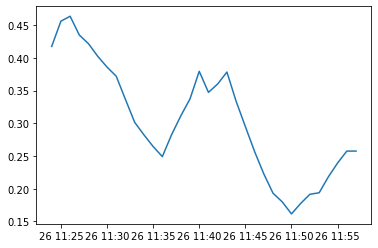

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D           J
time                                                 
2020-04-26 10:58:00  54.545455  51.515152   60.606061
2020-04-26 10:59:00  48.484848  50.505051   44.444444
2020-04-26 11:00:00  53.989899  51.666667   58.636364
2020-04-26 11:01:00  54.326599  52.553311   57.873176
2020-04-26 11:02:00  44.551066  49.885896   33.881407
2020-04-26 11:03:00  44.700711  48.157501   37.787131
2020-04-26 11:04:00  46.467141  47.594047   44.213327
2020-04-26 11:05:00  48.311427  47.833174   49.267933
2020-04-26 11:06:00  48.207618  47.957989   48.706877
2020-04-26 11:07:00  61.625591  52.513856   79.849062
2020-04-26 11:08:00  66.336253  57.121322   84.766115
2020-04-26 11:09:00  77.557502  63.933382  104.805742
2020-04-26 11:10:00  79.632929  69.166564  100.565659
2020-04-26 11:11:00  73.809340  70.714156   79.999708
2020-04-26 11:12:00  73.530551  71.652955   77.285744
2020-04-26 11:13:00  68.840187  70.715365   65.089831
2020-04-26 11:14:00  67.2267

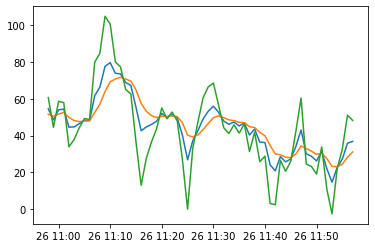

                             K          D           J
time                                                 
2020-04-26 10:58:00  58.225668  52.741889   69.193224
2020-04-26 10:59:00  55.911129  53.798302   60.136782
2020-04-26 11:00:00  39.104151  48.900252   19.511950
2020-04-26 11:01:00  27.594212  41.798239   -0.813842
2020-04-26 11:02:00  26.231804  36.609427    5.476558
2020-04-26 11:03:00  22.379864  31.866239    3.407114
2020-04-26 11:04:00  21.124907  28.285795    6.803131
2020-04-26 11:05:00  19.744312  25.438634    8.355668
2020-04-26 11:06:00  18.806335  23.227868    9.963269
2020-04-26 11:07:00  26.865967  24.440568   31.716766
2020-04-26 11:08:00  37.666074  28.849070   55.300082
2020-04-26 11:09:00  50.199557  35.965899   78.666874
2020-04-26 11:10:00  59.088262  43.673353   89.918080
2020-04-26 11:11:00  72.334605  53.227104  110.549608
2020-04-26 11:12:00  76.652352  61.035520  107.886017
2020-04-26 11:13:00  76.936678  66.335906   98.138223
2020-04-26 11:14:00  73.6488

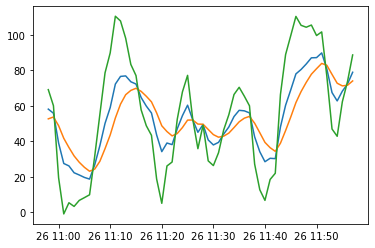

                             K          D           J
time                                                 
2020-04-26 10:58:00  48.484848  49.494949   46.464646
2020-04-26 10:59:00  48.989899  49.326599   48.316498
2020-04-26 11:00:00  41.301908  46.651702   30.602319
2020-04-26 11:01:00  29.244007  40.849137    6.033747
2020-04-26 11:02:00  24.624210  35.440828    2.990973
2020-04-26 11:03:00  18.916140  29.932599   -3.116778
2020-04-26 11:04:00  16.777427  25.547541   -0.762803
2020-04-26 11:05:00  21.126472  24.073851   15.231712
2020-04-26 11:06:00  27.534607  25.227436   32.148947
2020-04-26 11:07:00  39.409036  29.954636   58.317836
2020-04-26 11:08:00  53.195768  37.701680   84.183943
2020-04-26 11:09:00  67.315697  47.573019  106.801053
2020-04-26 11:10:00  74.506761  56.550933  110.418417
2020-04-26 11:11:00  79.458408  64.186758  110.001708
2020-04-26 11:12:00  79.922627  69.432048  100.903785
2020-04-26 11:13:00  75.976787  71.613627   84.703105
2020-04-26 11:14:00  73.2002

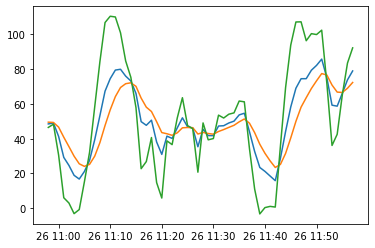

                             K          D           J
time                                                 
2020-04-26 10:58:00  62.500000  54.166667   79.166667
2020-04-26 10:59:00  75.000000  61.111111  102.777778
2020-04-26 11:00:00  82.051282  68.091168  109.971510
2020-04-26 11:01:00  63.675214  66.619183   57.787274
2020-04-26 11:02:00  49.977024  61.071797   27.787479
2020-04-26 11:03:00  33.318016  51.820537   -3.687025
2020-04-26 11:04:00  29.963949  44.535007    0.821831
2020-04-26 11:05:00  22.027248  37.032421   -7.983098
2020-04-26 11:06:00  15.189882  29.751575  -13.933502
2020-04-26 11:07:00  26.288204  28.597118   21.670377
2020-04-26 11:08:00  35.202237  30.798824   44.009063
2020-04-26 11:09:00  31.160466  30.919372   31.642655
2020-04-26 11:10:00  26.570745  29.469830   20.772577
2020-04-26 11:11:00  17.713830  25.551163    2.039165
2020-04-26 11:12:00  16.064539  22.388955    3.415708
2020-04-26 11:13:00  13.546572  19.441494    1.756729
2020-04-26 11:14:00  13.2863

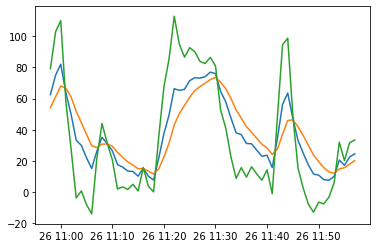

                             K          D           J
time                                                 
2020-04-26 10:58:00  33.333333  44.444444   11.111111
2020-04-26 10:59:00  23.391813  37.426901   -4.678363
2020-04-26 11:00:00  16.764133  30.539311  -10.786225
2020-04-26 11:01:00  12.345679  24.474767  -11.912497
2020-04-26 11:02:00   8.230453  19.059996  -13.428633
2020-04-26 11:03:00   5.486968  14.535653  -12.610401
2020-04-26 11:04:00   3.657979  10.909762  -10.845587
2020-04-26 11:05:00   2.438653   8.086059   -8.856160
2020-04-26 11:06:00   1.625768   5.932629   -6.987952
2020-04-26 11:07:00   1.083846   4.316368   -5.381198
2020-04-26 11:08:00   1.299764   3.310833   -2.722373
2020-04-26 11:09:00   0.866510   2.496059   -2.392589
2020-04-26 11:10:00   7.081738   4.024618   13.195977
2020-04-26 11:11:00  10.179928   6.076388   18.387006
2020-04-26 11:12:00  12.245387   8.132721   20.470719
2020-04-26 11:13:00   8.163592   8.143011    8.204752
2020-04-26 11:14:00  24.5333

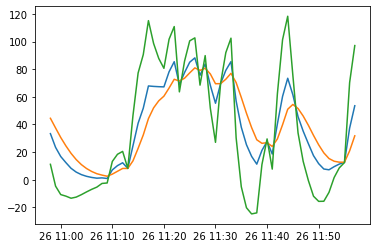

                             K          D           J
time                                                 
2020-04-26 10:58:00  42.907801  47.635934   33.451537
2020-04-26 10:59:00  58.605201  51.292356   73.230890
2020-04-26 11:00:00  47.116111  49.900274   41.547784
2020-04-26 11:01:00  33.421568  44.407372   11.449960
2020-04-26 11:02:00  23.347144  37.387296   -4.733162
2020-04-26 11:03:00  17.397039  30.723877   -9.256638
2020-04-26 11:04:00  11.598026  24.348593  -13.903109
2020-04-26 11:05:00   9.700191  19.465793   -9.831011
2020-04-26 11:06:00   9.942506  16.291364   -2.755209
2020-04-26 11:07:00  21.075574  17.886100   27.454520
2020-04-26 11:08:00  32.936480  22.902893   53.003652
2020-04-26 11:09:00  32.393790  26.066526   45.048319
2020-04-26 11:10:00  31.318082  27.817045   38.320158
2020-04-26 11:11:00  30.878722  28.837604   34.960958
2020-04-26 11:12:00  29.676723  29.117310   30.795550
2020-04-26 11:13:00  26.805916  28.346845   23.724057
2020-04-26 11:14:00  24.7841

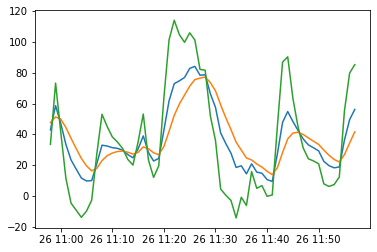

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

                             MACD   signal_line     histogram
time                                                         
2020-04-26 10:58:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 10:59:00 -6.730769e-08 -3.739316e-08 -2.991453e-08
2020-04-26 11:00:00 -8.576336e-08 -5.721701e-08 -2.854635e-08
2020-04-26 11:01:00 -1.642648e-07 -9.347980e-08 -7.078496e-08
2020-04-26 11:02:00 -4.422169e-07 -1.972212e-07 -2.449957e-07
2020-04-26 11:03:00 -4.299492e-07 -2.603034e-07 -1.696458e-07
2020-04-26 11:04:00 -3.693745e-07 -2.879064e-07 -8.146806e-08
2020-04-26 11:05:00 -4.179378e-07 -3.191554e-07 -9.878240e-08
2020-04-26 11:06:00 -4.948215e-07 -3.597351e-07 -1.350864e-07
2020-04-26 11:07:00  2.444111e-08 -2.736573e-07  2.980985e-07
2020-04-26 11:08:00  5.058769e-07 -1.030997e-07  6.089766e-07
2020-04-26 11:09:00  1.401269e-06  2.199755e-07  1.181293e-06
2020-04-26 11:10:00  1.820775e-06  5.587602e-07  1.262014e-06
2020-04-26 11:11:00  1.647483e-06  7.865218e-07  8.609609e-07
2020-04-

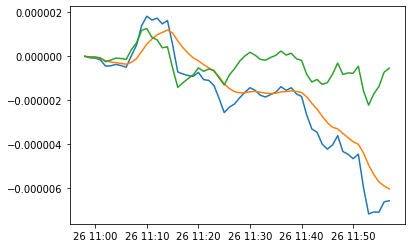

                         MACD  signal_line  histogram
time                                                 
2020-04-26 10:58:00  0.000000     0.000000   0.000000
2020-04-26 10:59:00  0.011442     0.006357   0.005085
2020-04-26 11:00:00 -0.184194    -0.071738  -0.112456
2020-04-26 11:01:00 -0.462902    -0.204246  -0.258656
2020-04-26 11:02:00 -0.486021    -0.288068  -0.197954
2020-04-26 11:03:00 -0.550221    -0.359126  -0.191095
2020-04-26 11:04:00 -0.553828    -0.408400  -0.145428
2020-04-26 11:05:00 -0.686692    -0.475279  -0.211414
2020-04-26 11:06:00 -0.768746    -0.543071  -0.225675
2020-04-26 11:07:00 -0.561313    -0.547158  -0.014154
2020-04-26 11:08:00 -0.338549    -0.501516   0.162966
2020-04-26 11:09:00 -0.297515    -0.457705   0.160190
2020-04-26 11:10:00 -0.254663    -0.414734   0.160071
2020-04-26 11:11:00 -0.099891    -0.348869   0.248978
2020-04-26 11:12:00 -0.057259    -0.288420   0.231161
2020-04-26 11:13:00 -0.068464    -0.243155   0.174691
2020-04-26 11:14:00 -0.07925

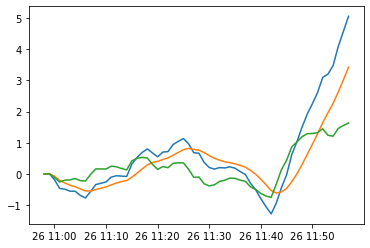

                         MACD  signal_line  histogram
time                                                 
2020-04-26 10:58:00  0.000000     0.000000   0.000000
2020-04-26 10:59:00  0.000224     0.000125   0.000100
2020-04-26 11:00:00 -0.004056    -0.001589  -0.002467
2020-04-26 11:01:00 -0.012040    -0.005129  -0.006911
2020-04-26 11:02:00 -0.014534    -0.007927  -0.006607
2020-04-26 11:03:00 -0.017471    -0.010514  -0.006957
2020-04-26 11:04:00 -0.018147    -0.012445  -0.005701
2020-04-26 11:05:00 -0.020686    -0.014426  -0.006260
2020-04-26 11:06:00 -0.019153    -0.015518  -0.003635
2020-04-26 11:07:00 -0.011091    -0.014526   0.003435
2020-04-26 11:08:00 -0.001913    -0.011766   0.009853
2020-04-26 11:09:00  0.005391    -0.008082   0.013473
2020-04-26 11:10:00  0.009042    -0.004458   0.013500
2020-04-26 11:11:00  0.012817    -0.000844   0.013660
2020-04-26 11:12:00  0.013126     0.002052   0.011074
2020-04-26 11:13:00  0.009556     0.003596   0.005960
2020-04-26 11:14:00  0.00919

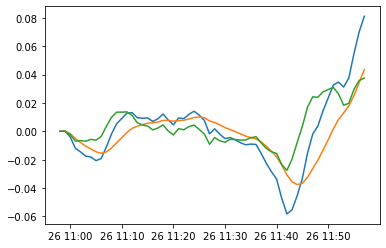

                             MACD   signal_line     histogram
time                                                         
2020-04-26 10:58:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 10:59:00  2.692308e-08  1.495726e-08  1.196581e-08
2020-04-26 11:00:00  5.291131e-08  3.051220e-08  2.239911e-08
2020-04-26 11:01:00 -1.553771e-09  1.964974e-08 -2.120352e-08
2020-04-26 11:02:00 -5.101272e-08 -1.370742e-09 -4.964198e-08
2020-04-26 11:03:00 -1.225460e-07 -3.421597e-08 -8.833001e-08
2020-04-26 11:04:00 -1.617800e-07 -6.649901e-08 -9.528095e-08
2020-04-26 11:05:00 -3.186538e-07 -1.270966e-07 -1.915573e-07
2020-04-26 11:06:00 -4.422830e-07 -1.999062e-07 -2.423768e-07
2020-04-26 11:07:00 -3.638686e-07 -2.366433e-07 -1.272253e-07
2020-04-26 11:08:00 -2.861194e-07 -2.474684e-07 -3.865104e-08
2020-04-26 11:09:00 -3.405800e-07 -2.674649e-07 -7.311519e-08
2020-04-26 11:10:00 -4.216421e-07 -3.000941e-07 -1.215480e-07
2020-04-26 11:11:00 -5.290025e-07 -3.479819e-07 -1.810206e-07
2020-04-

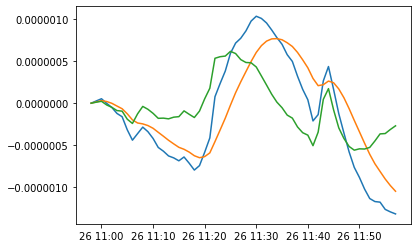

                             MACD   signal_line     histogram
time                                                         
2020-04-26 10:58:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 10:59:00  8.974359e-08  4.985755e-08  3.988604e-08
2020-04-26 11:00:00  1.143511e-07  7.628935e-08  3.806179e-08
2020-04-26 11:01:00  1.227407e-07  9.202490e-08  3.071579e-08
2020-04-26 11:02:00 -3.445376e-08  5.440036e-08 -8.885412e-08
2020-04-26 11:03:00 -1.283013e-07  4.878040e-09 -1.331794e-07
2020-04-26 11:04:00 -8.658020e-07 -2.154679e-07 -6.503342e-07
2020-04-26 11:05:00 -5.293862e-06 -1.435901e-06 -3.857961e-06
2020-04-26 11:06:00 -9.321548e-06 -3.257525e-06 -6.064023e-06
2020-04-26 11:07:00 -1.266118e-05 -5.364489e-06 -7.296687e-06
2020-04-26 11:08:00 -1.468378e-05 -7.403496e-06 -7.280282e-06
2020-04-26 11:09:00 -1.926274e-05 -9.950363e-06 -9.312373e-06
2020-04-26 11:10:00 -1.923975e-05 -1.191632e-05 -7.323430e-06
2020-04-26 11:11:00 -1.949427e-05 -1.350163e-05 -5.992634e-06
2020-04-

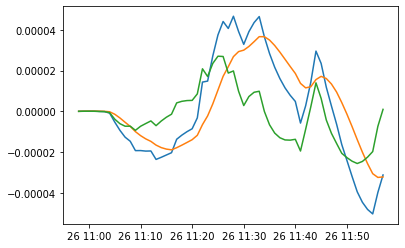

                         MACD  signal_line  histogram
time                                                 
2020-04-26 10:58:00  0.000000     0.000000   0.000000
2020-04-26 10:59:00  0.000263     0.000146   0.000117
2020-04-26 11:00:00  0.000040     0.000102  -0.000063
2020-04-26 11:01:00 -0.000969    -0.000260  -0.000708
2020-04-26 11:02:00 -0.001691    -0.000686  -0.001005
2020-04-26 11:03:00 -0.002064    -0.001059  -0.001004
2020-04-26 11:04:00 -0.002702    -0.001475  -0.001227
2020-04-26 11:05:00 -0.004066    -0.002098  -0.001969
2020-04-26 11:06:00 -0.004771    -0.002715  -0.002055
2020-04-26 11:07:00 -0.003851    -0.002970  -0.000881
2020-04-26 11:08:00 -0.002568    -0.002882   0.000314
2020-04-26 11:09:00 -0.002966    -0.002900  -0.000066
2020-04-26 11:10:00 -0.003566    -0.003041  -0.000525
2020-04-26 11:11:00 -0.003946    -0.003230  -0.000716
2020-04-26 11:12:00 -0.004306    -0.003453  -0.000853
2020-04-26 11:13:00 -0.004696    -0.003709  -0.000987
2020-04-26 11:14:00 -0.00471

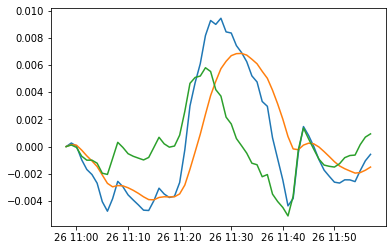

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

                         open      high       low     close   volume  \
time                                                                   
2020-04-26 11:36:00  0.025582  0.025585  0.025582  0.025583   46.964   
2020-04-26 11:37:00  0.025581  0.025583  0.025577  0.025578   16.420   
2020-04-26 11:38:00  0.025577  0.025581  0.025576  0.025581   11.939   
2020-04-26 11:39:00  0.025577  0.025583  0.025573  0.025576  104.399   
2020-04-26 11:40:00  0.025580  0.025581  0.025573  0.025577   96.016   
2020-04-26 11:41:00  0.025581  0.025582  0.025567  0.025567   97.717   
2020-04-26 11:42:00  0.025567  0.025577  0.025564  0.025567  112.129   
2020-04-26 11:43:00  0.025566  0.025571  0.025560  0.025571   68.933   
2020-04-26 11:44:00  0.025569  0.025578  0.025565  0.025565   94.368   
2020-04-26 11:45:00  0.025573  0.025574  0.025565  0.025567   29.936   
2020-04-26 11:46:00  0.025568  0.025574  0.025565  0.025571   50.303   
2020-04-26 11:47:00  0.025572  0.025575  0.025566  0.025574   61

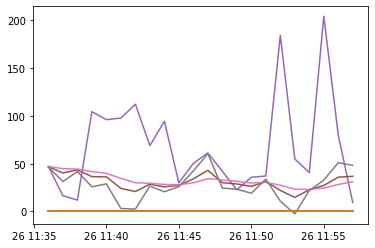

                        open     high      low    close     volume          K  \
time                                                                            
2020-04-26 11:36:00  7619.24  7619.98  7614.21  7618.16  25.716159  57.258158   
2020-04-26 11:37:00  7618.24  7621.27  7617.92  7618.01  15.646220  56.113560   
2020-04-26 11:38:00  7618.01  7618.01  7615.01  7615.31   4.246800  42.602619   
2020-04-26 11:39:00  7616.23  7617.81  7614.21  7615.44   6.588561  34.209111   
2020-04-26 11:40:00  7615.44  7615.75  7612.17  7613.75  16.764829  28.593620   
2020-04-26 11:41:00  7614.10  7614.69  7609.00  7613.22  21.045715  30.526689   
2020-04-26 11:42:00  7612.97  7614.69  7612.55  7612.67  10.067021  30.321243   
2020-04-26 11:43:00  7612.66  7619.28  7611.03  7619.28  18.018403  48.141356   
2020-04-26 11:44:00  7618.01  7624.35  7617.40  7622.04  28.245258  60.411284   
2020-04-26 11:45:00  7622.00  7624.35  7621.38  7622.26  23.073394  69.068977   
2020-04-26 11:46:00  7622.32

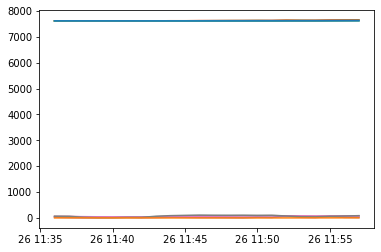

                       open    high     low   close      volume          K  \
time                                                                         
2020-04-26 11:36:00  194.91  194.93  194.80  194.90   277.44699  54.623194   
2020-04-26 11:37:00  194.85  194.97  194.81  194.82   236.40539  43.991220   
2020-04-26 11:38:00  194.81  194.82  194.77  194.79   187.54381  32.660814   
2020-04-26 11:39:00  194.81  194.82  194.78  194.78   234.08595  23.440542   
2020-04-26 11:40:00  194.78  194.78  194.73  194.77   141.89415  21.182584   
2020-04-26 11:41:00  194.76  194.76  194.59  194.64   514.27694  18.507687   
2020-04-26 11:42:00  194.64  194.67  194.62  194.63   115.92201  15.847230   
2020-04-26 11:43:00  194.62  194.78  194.53  194.77   389.57642  28.746638   
2020-04-26 11:44:00  194.78  194.94  194.77  194.86   535.97729  44.164426   
2020-04-26 11:45:00  194.87  194.96  194.84  194.91   153.78393  58.230829   
2020-04-26 11:46:00  194.92  195.06  194.87  195.01   404.15125 

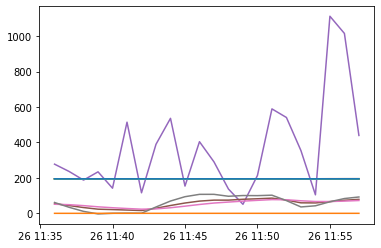

                         open      high       low     close  volume  \
time                                                                  
2020-04-26 11:36:00  0.002143  0.002143  0.002142  0.002142  163.81   
2020-04-26 11:37:00  0.002142  0.002143  0.002142  0.002143  204.35   
2020-04-26 11:38:00  0.002143  0.002143  0.002140  0.002141  295.47   
2020-04-26 11:39:00  0.002141  0.002141  0.002140  0.002141   80.44   
2020-04-26 11:40:00  0.002141  0.002141  0.002140  0.002141  214.08   
2020-04-26 11:41:00  0.002141  0.002141  0.002139  0.002139  156.74   
2020-04-26 11:42:00  0.002139  0.002143  0.002139  0.002143  307.74   
2020-04-26 11:43:00  0.002143  0.002147  0.002143  0.002147  843.65   
2020-04-26 11:44:00  0.002147  0.002147  0.002145  0.002145  302.36   
2020-04-26 11:45:00  0.002145  0.002145  0.002140  0.002140  416.69   
2020-04-26 11:46:00  0.002140  0.002140  0.002139  0.002139  304.28   
2020-04-26 11:47:00  0.002139  0.002139  0.002138  0.002139  192.54   
2020-0

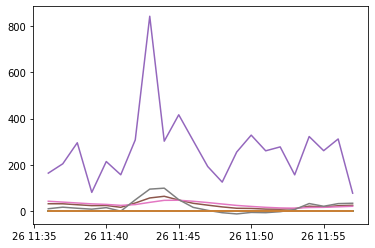

                         open      high       low     close  volume  \
time                                                                  
2020-04-26 11:36:00  0.083711  0.083711  0.083711  0.083711    0.00   
2020-04-26 11:37:00  0.083711  0.083711  0.083711  0.083711    0.00   
2020-04-26 11:38:00  0.083754  0.083754  0.083710  0.083710  148.07   
2020-04-26 11:39:00  0.083683  0.083711  0.083603  0.083711   22.37   
2020-04-26 11:40:00  0.083711  0.083711  0.083710  0.083710    4.12   
2020-04-26 11:41:00  0.083604  0.083604  0.083604  0.083604    5.08   
2020-04-26 11:42:00  0.083709  0.083820  0.083709  0.083820   49.12   
2020-04-26 11:43:00  0.083820  0.083884  0.083747  0.083884   18.04   
2020-04-26 11:44:00  0.083900  0.083966  0.083900  0.083965    5.66   
2020-04-26 11:45:00  0.083739  0.083739  0.083739  0.083739    2.38   
2020-04-26 11:46:00  0.083683  0.083683  0.083654  0.083654    0.48   
2020-04-26 11:47:00  0.083654  0.083654  0.083654  0.083654    0.00   
2020-0

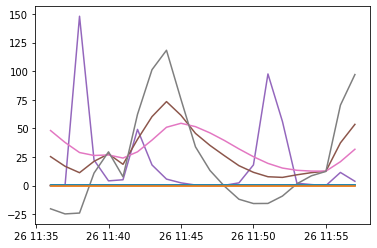

                        open     high      low    close   volume          K  \
time                                                                          
2020-04-26 11:36:00  16.3300  16.3300  16.3144  16.3158  2275.05  14.349423   
2020-04-26 11:37:00  16.3168  16.3264  16.3158  16.3264  1861.20  20.833887   
2020-04-26 11:38:00  16.3230  16.3230  16.2983  16.3002  3328.87  15.464714   
2020-04-26 11:39:00  16.3002  16.3043  16.2991  16.3036  1984.04  14.715462   
2020-04-26 11:40:00  16.3033  16.3042  16.2985  16.2991  1436.60  10.596935   
2020-04-26 11:41:00  16.2991  16.2999  16.2867  16.2899  1349.68   9.408946   
2020-04-26 11:42:00  16.2899  16.3155  16.2875  16.3155  2952.20  27.371532   
2020-04-26 11:43:00  16.3122  16.3615  16.3121  16.3528  3847.74  47.704016   
2020-04-26 11:44:00  16.3535  16.3697  16.3426  16.3439  4691.26  54.774565   
2020-04-26 11:45:00  16.3439  16.3458  16.3105  16.3161  1601.51  48.323605   
2020-04-26 11:46:00  16.3106  16.3182  16.3105  16.3

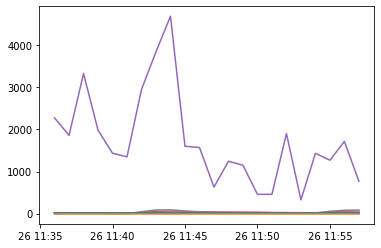

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([[msg['o'].rstrip('0').rstrip('.'), 
                           msg['h'].rstrip('0').rstrip('.'), 
                           msg['l'].rstrip('0').rstrip('.'), 
                           msg['c'].rstrip('0').rstrip('.'), 
                           msg['v'].rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()

scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(10)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = random.choice(target_symbols)
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol

best_assets:  ['BTC', 'BNB']
best_assets:  ['BTC', 'BNB']
best_assets:  ['BTC', 'BNB']
best_assets:  ['BTC', 'USDT']
best_assets:  ['ETH', 'BTC']
best_assets:  ['BTC', 'BNB']
best_assets:  ['BTC', 'USDT']
quote_asset_buy_balance:  0.00030629
base_asset_buy_last_price:  0.025516
base_asset_buy_balance:  0.012003840727386738
base_asset_sell_balance:  0.5098958
quote_asset_sell_last_price:  0.02552
quote_asset_sell_balance:  0.013012540816000001
quote_asset_balance_combined:  0.013318830816000002
base_asset_balance_combined:  0.5218996407273867

Position for base asset ETH is sell.
Position for quote asset BTC is buy.
State is exit.

best_assets:  ['BTC']


In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()